# Sin

In [1]:
#Start by importing the following libraries
#data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', size=24)
plt.rc('axes', titlesize=24)

#linear-tree objects
from lineartree import LinearTreeRegressor
from sklearn.linear_model import LinearRegression

#pyomo for optimization
import pyomo.environ as pyo

#omlt for interfacing our neural network with pyomo
from omlt import OmltBlock
from omlt.lineartree import LinearTreeGDPFormulation, LinearTreeModel
import omlt

import numpy as np
import pyomo.environ as pe

from omlt.formulation import _PyomoFormulation, _setup_scaled_inputs_outputs
from pyomo.gdp import Disjunct, Disjunction
import pprint
pp = pprint.PrettyPrinter(indent=4)

import lightgbm as lgb
from collections import defaultdict
from collections import deque


In [2]:
df = pd.read_csv("./data/sin_quadratic.csv",index_col=[0])

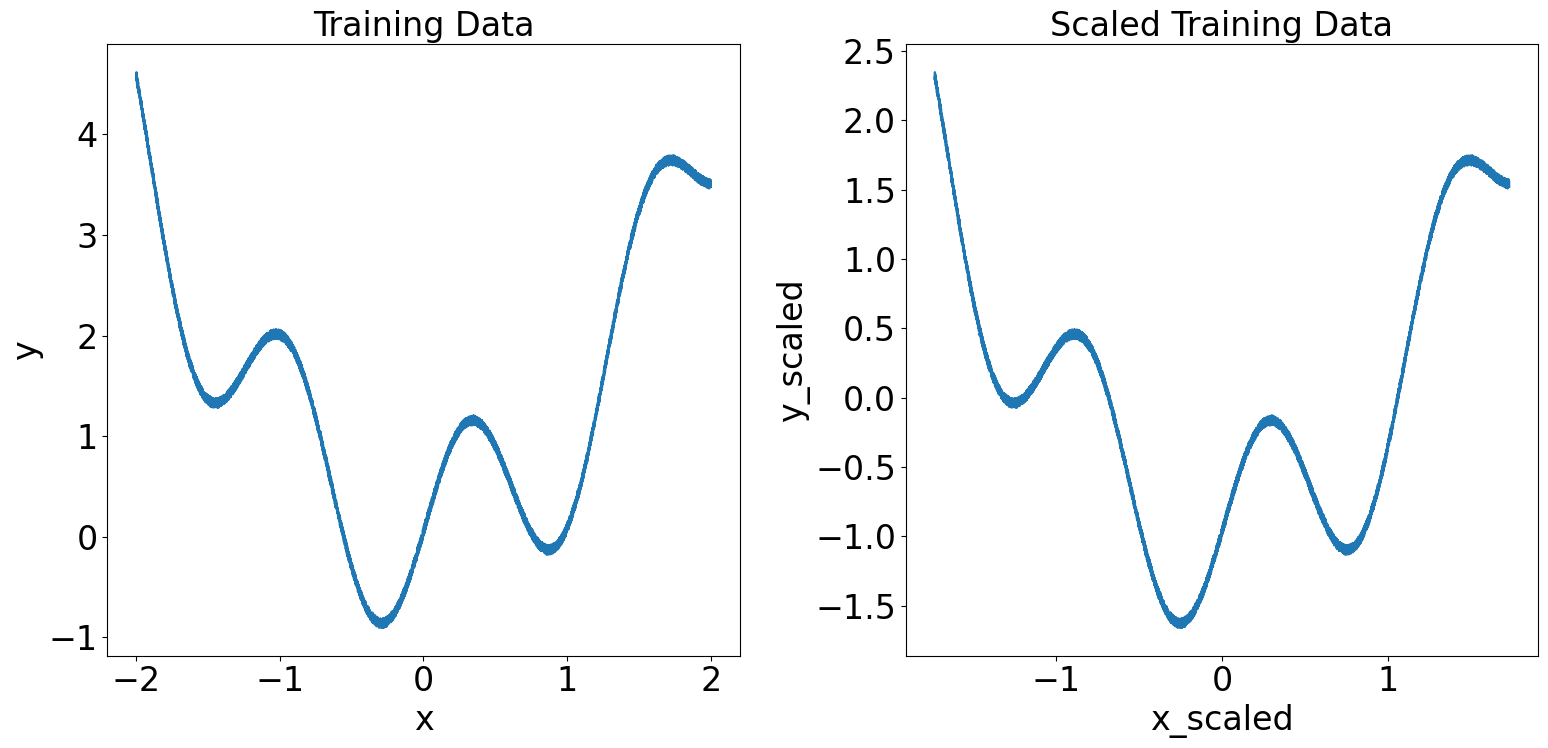

In [3]:
#retrieve input 'x' and output 'y' from the dataframe
x = df["x"]
y = df["y"]

#calculate mean and standard deviation, add scaled 'x' and scaled 'y' to the dataframe
mean_data = df.mean(axis=0)
std_data = df.std(axis=0)
df["x_scaled"] = (df['x'] - mean_data['x']) / std_data['x']
df["y_scaled"] = (df['y'] - mean_data['y']) / std_data['y']

#create plots for unscaled and scaled data
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.plot(x, y)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Training Data")

ax2.plot(df["x_scaled"], df["y_scaled"])
ax2.set_xlabel("x_scaled")
ax2.set_ylabel("y_scaled")
ax2.set_title("Scaled Training Data")

plt.tight_layout()


In [4]:
#Data needs to be in array and reshaped
x_scaled = df["x_scaled"].to_numpy().reshape(-1,1)
y_scaled = df["y_scaled"].to_numpy().reshape(-1,1)

In [5]:
PARAMS = {'objective': 'regression',
            'metric': 'rmse',
            'boosting': 'gbdt',
            'learning_rate': 0.5,
            'num_trees': 2,
            'max_depth': 2,
            # 'min_data_in_leaf': 2,
            # 'random_state': 100,
            'verbose': -1}
train_data = lgb.Dataset(x_scaled, 
                            label=y_scaled,
                            params={'verbose': -1})

model = lgb.train(PARAMS, 
                    train_data,
                    verbose_eval=False)

c:\Users\shumengl\.conda\envs\omlt_lt\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_trees` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\shumengl\.conda\envs\omlt_lt\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\shumengl\.conda\envs\omlt_lt\lib\site-packages\lightgbm\basic.py:179: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


In [6]:
# model.dump_model()

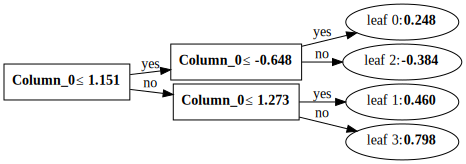

In [7]:
import os
os.environ["PATH"] += os.pathsep + 'C:\Program Files\Graphviz\\bin'
# lgb.plot_tree(model_linear)
# for i in range(params['num_iterations']):
# p = lgb.create_tree_digraph(model_linear, params['num_iterations'] - 1)
p = lgb.create_tree_digraph(model, 0)
p

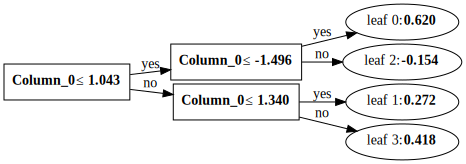

In [8]:
p = lgb.create_tree_digraph(model, 1)
p

In [9]:
from onnxmltools.convert.lightgbm.convert import convert
from skl2onnx.common.data_types import FloatTensorType

lgb_model = model
float_tensor_type = FloatTensorType([None, lgb_model.num_feature()])
initial_types = [('float_input', float_tensor_type)]
onnx_model = convert(lgb_model, 
                        initial_types=initial_types, 
                        target_opset=8)

In [10]:
graph = onnx_model.graph

In [11]:
graph

node {
  input: "float_input"
  output: "variable"
  name: "LgbmRegressor"
  op_type: "TreeEnsembleRegressor"
  attribute {
    name: "n_targets"
    i: 1
    type: INT
  }
  attribute {
    name: "nodes_falsenodeids"
    ints: 2
    ints: 4
    ints: 6
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 2
    ints: 4
    ints: 6
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    type: INTS
  }
  attribute {
    name: "nodes_featureids"
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    ints: 0
    type: INTS
  }
  attribute {
    name: "nodes_hitrates"
    floats: 1.0
    floats: 1.0
    floats: 1.0
    floats: 1.0
    floats: 1.0
    floats: 1.0
    floats: 1.0
    floats: 1.0
    floats: 1.0
    floats: 1.0
    floats: 1.0
    floats: 1.0
    floats: 1.0
    floats: 1.0
    type: FLOATS
  }
  attribute {
    name: "nodes_missing_value_tracks_true"
    ints: 1
    ints:

In [12]:
def _node_attributes(node):
    attr = dict()
    for at in node.attribute:
        attr[at.name] = at
    return attr

root_node = graph.node[0]
attr = _node_attributes(root_node)

# attr
base_value = (
    np.array(attr["base_values"].floats)[
        0] if "base_values" in attr else 0.0
)

# default left true
nodes_feature_ids = np.array(attr["nodes_featureids"].ints)
nodes_values = np.array(attr["nodes_values"].floats)
nodes_modes = np.array(attr["nodes_modes"].strings)
nodes_tree_ids = np.array(attr["nodes_treeids"].ints)
nodes_node_ids = np.array(attr["nodes_nodeids"].ints)
nodes_false_node_ids = np.array(attr["nodes_falsenodeids"].ints)
nodes_true_node_ids = np.array(attr["nodes_truenodeids"].ints)

n_targets = attr["n_targets"].i # assert is 1 or not
target_ids = np.array(attr["target_ids"].ints) # assert is same or not
target_node_ids = np.array(attr["target_nodeids"].ints)
target_tree_ids = np.array(attr["target_treeids"].ints)
target_weights = np.array(attr["target_weights"].floats)

nodes_leaf_mask = nodes_modes == b"LEAF"
nodes_branch_mask = nodes_modes == b"BRANCH_LEQ"

tree_ids = set(nodes_tree_ids)
feature_ids = set(nodes_feature_ids)

In [13]:
from collections import defaultdict
from collections import deque

splits_dic = defaultdict(dict)
leaves_dic = defaultdict(dict)
for i in tree_ids:
    # splits_dic[i] = {"node": nodes_node_ids[nodes_tree_ids==i]}
    node = nodes_node_ids[nodes_tree_ids==i]
    feature = nodes_feature_ids[nodes_tree_ids==i]
    value = nodes_values[nodes_tree_ids == i]
    mode = nodes_modes[nodes_tree_ids == i]
    target_weight = target_weights[target_tree_ids == i]
    count = 0
    count_leaf = 0
    queue = deque([node[count]])
    while queue:
        cur = queue[0]
        queue.popleft()
        # print(cur, mode[cur])
        if mode[cur] == b'BRANCH_LEQ':
            splits_dic[i][cur] = {'th': value[cur],
                                'col': feature[cur],
                                'children': [None, None]}
            queue.appendleft(node[count + 2])
            splits_dic[i][cur]['children'][0] = node[count+1]
            queue.appendleft(node[count + 1])
            splits_dic[i][cur]['children'][1] = node[count+2]
            count += 2
        else:
            # print(cur, i, count_leaf, target_weight[count_leaf])
            leaves_dic[i][cur] = {'val': target_weight[count_leaf]}
            count_leaf += 1

splits_dic, leaves_dic

(defaultdict(dict,
             {0: {0: {'th': 1.1510634422302246, 'col': 0, 'children': [1, 2]},
               1: {'th': -0.6484473943710327, 'col': 0, 'children': [3, 4]},
               2: {'th': 1.2726472616195679, 'col': 0, 'children': [5, 6]}},
              1: {0: {'th': 1.042988896369934, 'col': 0, 'children': [1, 2]},
               1: {'th': -1.4964170455932617, 'col': 0, 'children': [3, 4]},
               2: {'th': 1.3401938676834106, 'col': 0, 'children': [5, 6]}}}),
 defaultdict(dict,
             {0: {3: {'val': 0.2479362189769745},
               4: {'val': -0.38389769196510315},
               5: {'val': 0.4595942795276642},
               6: {'val': 0.7975010871887207}},
              1: {3: {'val': 0.6200382113456726},
               4: {'val': -0.15379340946674347},
               5: {'val': 0.2716177999973297},
               6: {'val': 0.4180242717266083}}}))

In [14]:
nodes_modes[0] == b'BRANCH_LEQ'
list(zip(nodes_tree_ids[nodes_leaf_mask], nodes_node_ids[nodes_leaf_mask]))
nodes_feature_mask = nodes_feature_ids == f
nodes_feature_mask


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])